In [1]:
import os
import json
from collections import defaultdict

import pandas as pd
import numpy as np
import einops

import torch
import torch.nn.functional as F
from fancy_einsum import einsum
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from transformer_lens import HookedTransformer
from toxicity.figures.fig_utils import convert, load_hooked, get_svd
from constants import MODEL_DIR, DATA_DIR

torch.set_grad_enabled(False)

In [2]:

model = load_hooked("gpt2-medium", os.path.join(MODEL_DIR, "dpo.pt"))
gpt2 = HookedTransformer.from_pretrained("gpt2-medium")
gpt2.tokenizer.padding_side = "left"
gpt2.tokenizer.pad_token_id = gpt2.tokenizer.eos_token_id

toxic_vector = torch.load(os.path.join(MODEL_DIR, "probe.pt"))

cos = F.cosine_similarity

Loaded pretrained model gpt2-medium into HookedTransformer
Loaded pretrained model gpt2-medium into HookedTransformer


In [3]:

with open(
    os.path.join(DATA_DIR, "intervene_data/challenge_prompts.jsonl"), "r"
) as file_p:
    data = file_p.readlines()

prompts = [json.loads(x.strip())["prompt"] for x in data]
tokenized_prompts = model.to_tokens(prompts, prepend_bos=True).cuda()

In [4]:


svd_gpt2, scores_gpt2 = get_svd(gpt2, toxic_vector, 128)

mlps_by_layer = {}
for _score_obj in scores_gpt2:
    layer = _score_obj[2]
    if layer not in mlps_by_layer:
        mlps_by_layer[layer] = []
    mlps_by_layer[layer].append(_score_obj[1])

vectors_of_interest = [
    (_score_obj[2], _score_obj[1], _score_obj[0])
    for _score_obj in scores_gpt2[:64]
]

In [5]:


sample_size = tokenized_prompts.shape[0]
layer_of_interest = 18

sublayers = [0, 2, 4, 6, 8, 9, 11, 13, 15, 17]
batch_size = 4

all_diffs = []
for idx in tqdm(range(0, sample_size, batch_size)):
    batch = tokenized_prompts[idx : idx + batch_size, :]
    with torch.inference_mode():
        _, cache = gpt2.run_with_cache(batch)

    gpt2_resids = {}
    # [batch, d_model]
    gpt2_resids[layer_of_interest] = cache[
        f"blocks.{layer_of_interest}.hook_resid_mid"
    ]

    with torch.inference_mode():
        _, cache = model.run_with_cache(batch)

    # [batch, d_model]
    all_diffs.append(
        cache[f"blocks.{layer_of_interest}.hook_resid_mid"]
        - gpt2_resids[layer_of_interest]
    )

all_diffs = torch.concat(all_diffs, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  8.84it/s]


In [6]:

# [4096, 1024]
mlp_diffs = {}
for _layer in sublayers:
    dpo_w_out = model.blocks[_layer].mlp.W_out
    gpt2_w_out = gpt2.blocks[_layer].mlp.W_out
    mlp_diffs[_layer] = dpo_w_out - gpt2_w_out


diff_cosines = {}

for mlp_layer in sublayers:

    diff_cosines[mlp_layer] = cos(
        mlp_diffs[mlp_layer],
        all_diffs.view(-1, 1024).mean(dim=0).unsqueeze(0),
        dim=1,
    ).tolist()

In [7]:

all_acts_dpo_pt = defaultdict(list)
# Decompose layer 19 MLP out
print("Grabbing mlp mids...")
for idx in tqdm(range(0, sample_size, batch_size)):
    batch = tokenized_prompts[idx : idx + batch_size, :]
    with torch.inference_mode():
        _, cache = model.run_with_cache(batch)

    for _layer in sublayers:
        mlp_mid = cache[f"blocks.{_layer}.mlp.hook_post"]
        all_acts_dpo_pt[_layer].append(mlp_mid.cpu())

Grabbing mlp mids...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:20<00:00, 14.74it/s]


In [8]:

d_mlp = model.cfg.d_mlp
dpo_acts_mean = {}
gpt2_acts_mean = {}
for _layer in sublayers:
    concat = torch.concat([x.cuda() for x in all_acts_dpo_pt[_layer]], dim=0)
    dpo_acts_mean[_layer] = (
        concat.view(-1, d_mlp).to("cuda:1").mean(dim=0).cpu()
    )

In [9]:

print("Building dataframes.")

raw_cosine_data = []
layers_to_plot = list(diff_cosines.keys())
for _layer in layers_to_plot:
    for _idx in range(d_mlp):
        raw_cosine_data.append(
            {
                "layer": _layer,
                "cos_sim": round(diff_cosines[_layer][_idx], 2),
            }
        )

raw_mean_acts = []
for _layer in layers_to_plot:
    for _idx in range(d_mlp):
        raw_mean_acts.append(
            {"layer": _layer, "mean_acts": dpo_acts_mean[_layer][_idx].item()}
        )


cos_sim_df = pd.DataFrame(raw_cosine_data)
mean_acts_df = pd.DataFrame(raw_mean_acts)

Building dataframes.


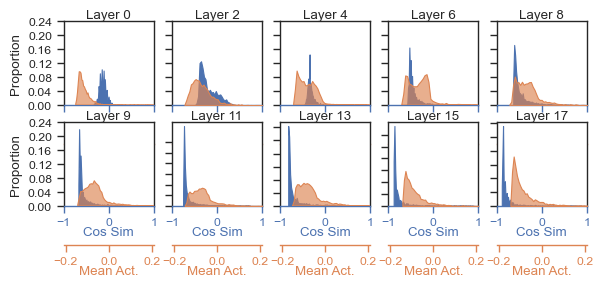

In [10]:

sns.set_theme(context="paper", style="ticks", rc={"lines.linewidth": 1})

colors = sns.color_palette()

num_cols = int(len(sublayers) / 2)

fig = plt.figure(figsize=(6.75, 2.4))
gs = GridSpec(2, num_cols)

yticks = [0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24]
edge_col = 0

for idx in range(num_cols * 2):
    curr_row = idx // num_cols
    curr_col = idx % num_cols

    _layer = sublayers[idx]
    ax = fig.add_subplot(gs[curr_row, curr_col])

    ax.set(yticks=yticks)
    ax2 = ax.twiny()
    sns.histplot(
        data=cos_sim_df[cos_sim_df.layer == _layer],
        x="cos_sim",
        ax=ax,
        stat="probability",
        color=colors[0],
        alpha=1,
        element="poly",
    )
    sns.histplot(
        data=mean_acts_df[mean_acts_df.layer == _layer],
        x="mean_acts",
        ax=ax2,
        stat="probability",
        color=colors[1],
        alpha=0.65,
        element="poly",
    )

    ax.set_title(f"Layer {_layer}", pad=-10)

    ax.set(yticks=yticks)
    ax.set(xticks=[-1, 0, 1])
    ax.yaxis.tick_left()
    if curr_col != edge_col:
        ax.yaxis.set_visible(True)
        ax.yaxis.set_ticklabels([])
        ax.yaxis.label.set_visible(False)

    else:
        ax.yaxis.label.set_visible(True)
        ax.yaxis.label.set_text("Proportion")

    if curr_row == 0:
        ax.xaxis.label.set_visible(False)
        ax.xaxis.set_ticklabels([])
        ax2.xaxis.set_visible(False)

    ax2.set_xlim(left=-0.21, right=0.21)

    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("outward", 28))
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    for sp in ax2.spines.values():
        sp.set_visible(False)
    ax2.spines["bottom"].set_visible(True)

    ax.spines["bottom"].set_color(colors[0])
    ax2.spines["bottom"].set_color(colors[1])

    ax.xaxis.label.set_color(colors[0])
    ax.tick_params(axis="x", colors=colors[0])

    ax2.xaxis.label.set_color(colors[1])
    ax2.tick_params(axis="x", colors=colors[1])

    ax2.set(xticks=[-0.2, 0, 0.2])
    ax.xaxis.label.set_text("Cos Sim")
    ax2.xaxis.label.set_text("Mean Act.")
    ax.xaxis.labelpad = -1
    ax2.xaxis.labelpad = -1

fig.savefig(
    f"resid_diff_subplots_layer{layer_of_interest}.pdf",
    bbox_inches="tight",
    dpi=1200,
)